DS4400 Final Project

Araya Kartik, Kaito Minami, Sophia Watanabe
# Dog Breed Classifier

## 1. Image Processing function

In [1]:
import numpy as np
import cv2
import os


def crop_image(image, crop_size):
    # Crop image to specified size
    h, w = image.shape[:2]
    if h > crop_size[0] and w > crop_size[1]:
        return image[(h - crop_size[0]) // 2:(h + crop_size[0]) // 2, (w - crop_size[1]) // 2:(w + crop_size[1]) // 2]
    else:
        return cv2.resize(image, crop_size)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Image dataset split

In [3]:
!python --version

Python 3.10.12


In [4]:
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop #, adam
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from keras.utils import to_categorical
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import random
from PIL import Image
# import theano

import time
import keras.callbacks as cb
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.optimizers import  RMSprop

In [5]:
def split(path_, categories_):
    # Step 3: Creating training data
    training = []
    for category in categories_:
        path = os.path.join(path_, category)
        class_num = categories_.index(category)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img))
            new_array = crop_image(img_array, [IMG_SIZE, IMG_SIZE])
            training.append([new_array, class_num])

    # Step 4: Shuffle the Dataset
    random.shuffle(training)

    # Step 5: Assigning Labels and Features
    X =[]
    y =[]
    for features, label in training:
      X.append(features)
      y.append(label)
    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

    # Step 6: Normalizing X and Converting Labels to Categorical Data
    X = X.astype('float32') # OpenCV initially stores value as uint8. Floating-point is preferrable for Neural Networks
    X /= 255 # X will now be floating point between 0 and 1, easier to categorize
    # np_utils (Python 3.10)
    Y = to_categorical(y, len(categories_)) # One Hot Encoding
    y = np.array(y).reshape(-1,)

    # Step 7: Split X and Y for Use in CNN
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size = 0.25, # 75:25 training:testing ratio
        random_state = len(categories_)
    )

    return [X_train, X_test, y_train, y_test]

## 3. Convolutional Neural Network model

In [6]:
# we need to tune the Dense layers
def init_model(categories_):
    model = Sequential([
      Convolution2D(32, (3,3), padding='same', activation=tf.nn.relu,
                            input_shape=(IMG_SIZE, IMG_SIZE, 3)),
      BatchNormalization(),
      MaxPooling2D((2, 2), strides=2),
      Convolution2D(32, (3,3), padding='same', activation=tf.nn.relu),
      BatchNormalization(),
      MaxPooling2D((2, 2), strides=2),
      Dropout(0.8), # increased dropout
      Flatten(),
      Dense(16, activation=tf.nn.relu, kernel_regularizer=l2(0.001)), # reduced layer
      BatchNormalization(),
      Dropout(0.5),
      Dense(len(categories_), activation=tf.nn.softmax)
    ])
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

In [7]:
# Define the learning rate scheduler function
# def lr_scheduler(epoch, lr):
#     decay_rate = 0.1
#     decay_step = 10
#     if epoch % decay_step == 0 and epoch:
#         return lr * decay_rate
#     return lr

def run_network(data, model=None, epochs=20, batch=8): # 256, 32
    try:
        start_time = time.time()
        X_train, X_test, y_train, y_test = data
        # early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        # lr_callback = LearningRateScheduler(lr_scheduler)

        print("Training model")
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch, validation_data=(X_test, y_test), verbose=2)#, callbacks=[early_stopping])

        print("Training duration:"+format(time.time()-start_time))
        score = model.evaluate(X_test, y_test, batch_size=16)

        print("\nNetwork's test loss and accuracy:"+format(score))
        return history
    except KeyboardInterrupt:
        print("KeyboardInterrupt")
        return history

In [8]:
def plot_losses(hist):

  fig, axs = plt.subplots(1,2)
  axs[0].plot(hist.history['loss'])
  axs[0].plot(hist.history['val_loss'])
  axs[0].set_title('Model Loss')
  axs[0].set_ylabel('Loss')
  axs[0].set_xlabel('Epoch')
  axs[0].legend(['Train', 'Test'], loc='upper right')

  axs[1].plot(hist.history['accuracy'])
  axs[1].plot(hist.history['val_accuracy'])
  axs[1].set_title('Model Accuracy')
  axs[1].set_ylabel('Accuracy')
  axs[1].set_xlabel('Epoch')
  axs[1].legend(['Train', 'Test'], loc='upper right')
  plt.show()

## 4. Running functions

For using Google Colab free version, we limited the number of dog breed from 120 to top 10 and the number of images from 20580 to 2648.

In [9]:
master_path = '/content/drive/MyDrive/Colab Notebooks/Images'
category_ = ['n02097658-silky_terrier', 'n02092002-Scottish_deerhound', 'n02099849-Chesapeake_Bay_retriever', 'n02091244-Ibizan_hound', 'n02095314-wire-haired_fox_terrier', 'n02091831-Saluki', 'n02102318-cocker_spaniel', 'n02104365-schipperke', 'n02090622-borzoi', 'n02113023-Pembroke', 'n02105505-komondor', 'n02093256-Staffordshire_bullterrier', 'n02113799-standard_poodle', 'n02109961-Eskimo_dog', 'n02089973-English_foxhound', 'n02099601-golden_retriever', 'n02095889-Sealyham_terrier', 'n02085782-Japanese_spaniel', 'n02097047-miniature_schnauzer', 'n02110063-malamute', 'n02105162-malinois', 'n02086079-Pekinese', 'n02097130-giant_schnauzer', 'n02113978-Mexican_hairless', 'n02107142-Doberman', 'n02097209-standard_schnauzer', 'n02115913-dhole', 'n02106662-German_shepherd', 'n02106382-Bouvier_des_Flandres', 'n02110185-Siberian_husky', 'n02094258-Norwich_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02109525-Saint_Bernard', 'n02093754-Border_terrier', 'n02105251-briard', 'n02108551-Tibetan_mastiff', 'n02108422-bull_mastiff', 'n02085936-Maltese_dog', 'n02093859-Kerry_blue_terrier', 'n02104029-kuvasz', 'n02107574-Greater_Swiss_Mountain_dog', 'n02095570-Lakeland_terrier', 'n02086646-Blenheim_spaniel', 'n02088238-basset', 'n02098286-West_Highland_white_terrier', 'n02085620-Chihuahua', 'n02106166-Border_collie', 'n02090379-redbone', 'n02090721-Irish_wolfhound', 'n02088632-bluetick', 'n02113712-miniature_poodle', 'n02113186-Cardigan', 'n02108000-EntleBucher', 'n02091467-Norwegian_elkhound', 'n02100236-German_short-haired_pointer', 'n02107683-Bernese_mountain_dog', 'n02086910-papillon', 'n02097474-Tibetan_terrier', 'n02101006-Gordon_setter', 'n02093428-American_Staffordshire_terrier', 'n02100583-vizsla', 'n02105412-kelpie', 'n02092339-Weimaraner', 'n02107312-miniature_pinscher', 'n02108089-boxer', 'n02112137-chow', 'n02105641-Old_English_sheepdog', 'n02110958-pug', 'n02087394-Rhodesian_ridgeback', 'n02097298-Scotch_terrier', 'n02086240-Shih-Tzu', 'n02110627-affenpinscher', 'n02091134-whippet', 'n02102480-Sussex_spaniel', 'n02091635-otterhound', 'n02099267-flat-coated_retriever', 'n02100735-English_setter', 'n02091032-Italian_greyhound', 'n02099712-Labrador_retriever', 'n02106030-collie', 'n02096177-cairn', 'n02106550-Rottweiler', 'n02096294-Australian_terrier', 'n02087046-toy_terrier', 'n02105855-Shetland_sheepdog', 'n02116738-African_hunting_dog', 'n02111277-Newfoundland', 'n02089867-Walker_hound', 'n02098413-Lhasa', 'n02088364-beagle', 'n02111889-Samoyed', 'n02109047-Great_Dane', 'n02096051-Airedale', 'n02088466-bloodhound', 'n02100877-Irish_setter', 'n02112350-keeshond', 'n02096437-Dandie_Dinmont', 'n02110806-basenji', 'n02093647-Bedlington_terrier', 'n02107908-Appenzeller', 'n02101556-clumber', 'n02113624-toy_poodle', 'n02111500-Great_Pyrenees', 'n02102040-English_springer', 'n02088094-Afghan_hound', 'n02101388-Brittany_spaniel', 'n02102177-Welsh_springer_spaniel', 'n02096585-Boston_bull', 'n02115641-dingo', 'n02098105-soft-coated_wheaten_terrier', 'n02099429-curly-coated_retriever', 'n02108915-French_bulldog', 'n02102973-Irish_water_spaniel', 'n02112018-Pomeranian', 'n02112706-Brabancon_griffon', 'n02094433-Yorkshire_terrier', 'n02105056-groenendael', 'n02111129-Leonberg', 'n02089078-black-and-tan_coonhound']
short_category = ['n02085936-Maltese_dog', 'n02088094-Afghan_hound', 'n02092002-Scottish_deerhound', 'n02112018-Pomeranian', 'n02107683-Bernese_mountain_dog', 'n02111889-Samoyed', 'n02090721-Irish_wolfhound', 'n02086240-Shih-Tzu', 'n02111500-Great_Pyrenees', 'n02111129-Leonberg'] # length 10 top 10
IMG_SIZE = 300

In [10]:
data = split(master_path, short_category)

In [11]:
model = init_model(short_category)
history = run_network(data, model)

Training model
Epoch 1/20
210/210 - 275s - loss: 2.8895 - accuracy: 0.1535 - val_loss: 2.5796 - val_accuracy: 0.1413 - 275s/epoch - 1s/step
Epoch 2/20
210/210 - 249s - loss: 2.6290 - accuracy: 0.2031 - val_loss: 2.4964 - val_accuracy: 0.2451 - 249s/epoch - 1s/step
Epoch 3/20
210/210 - 276s - loss: 2.6997 - accuracy: 0.2312 - val_loss: 2.6375 - val_accuracy: 0.2487 - 276s/epoch - 1s/step
Epoch 4/20
210/210 - 247s - loss: 2.6562 - accuracy: 0.2503 - val_loss: 2.7021 - val_accuracy: 0.2630 - 247s/epoch - 1s/step
Epoch 5/20
210/210 - 253s - loss: 2.6827 - accuracy: 0.2772 - val_loss: 2.6317 - val_accuracy: 0.3238 - 253s/epoch - 1s/step
Epoch 6/20
210/210 - 250s - loss: 2.6568 - accuracy: 0.3202 - val_loss: 2.6815 - val_accuracy: 0.3095 - 250s/epoch - 1s/step
Epoch 7/20
210/210 - 254s - loss: 2.6599 - accuracy: 0.3303 - val_loss: 2.6889 - val_accuracy: 0.3417 - 254s/epoch - 1s/step
Epoch 8/20
210/210 - 270s - loss: 2.6831 - accuracy: 0.3417 - val_loss: 2.9062 - val_accuracy: 0.2701 - 270s/e

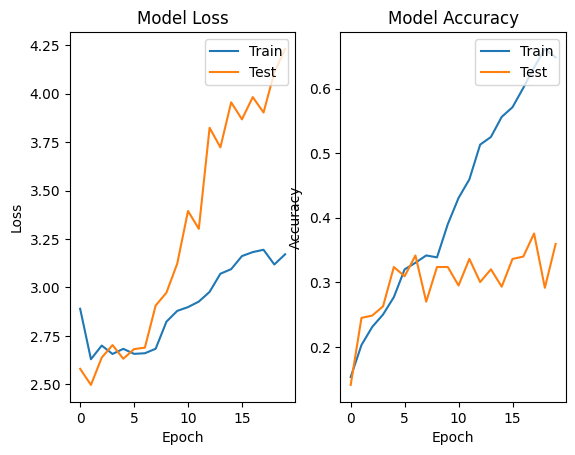

In [12]:
plot_losses(history)

In [13]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score
# import pandas as pd
# clf = LogisticRegression(max_iter=1000)
# X_train, X_test, y_train, y_test = data
# X_train = X_train.reshape(X_train.shape[0], -1)
# X_test = X_test.reshape(X_test.shape[0], -1)

# clf.fit(X_train, y_train)

# y_pred = clf.predict(X_test)
# print(accuracy_score(y_test, y_pred))